# POS stock equilibrium 

This notebook attempts to approximate the equilibrium distribution of POS SIM stock resulting from customer buy SIM and POS buying SIM bulks from upstream delears. 

Several simplifications have been made, which should have an impact on the result (hopefully not too large): 

* POS are modelled here as all being equally likely to be selected by a customer to purchase a SIM, whereas the real simulator have allocate them an "attractiveness" + let this attractivenes evolve during the data generation.

* All computations below are made assuming iterations of 1 day, whereas the actual simulator allows different values for the clock step 




In [5]:
from __future__ import division
import pandas as pd
import numpy as np 
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt

from trumania.core import util_functions, operations

import pos_stocks

import readline
%load_ext rpy2.ipython


%matplotlib inline

ImportError: No module named trumania.core

In [6]:
%%R
library(ggplot2)
library(repr)

In [ ]:
pd.read

# Customer buying sims

We simplify the model for customers buy SIMS by assuming all customers buy a sim every `sim_buy_mean_period_days` days => the number of SIM bought every day is

$$
    n = \frac{\text{n_customers}}{\text{sim_buy_mean_period_days}}
$$

And because we have `n_pos` point of sales, each POS has a probability `p` of being chosen: 

$$
    p = \frac{1}{\text{n_pos}}
$$

Based on that we can build the stock level transition matrix corresponding to those SIM purchases with: 

$$
\begin{split}
    P(s, s-k) & = \text{Binom}(k | n, p)\ \ \text{for k} \in [0, n] \\
              & = 0 \ \ \text{for k} < 0\ \ \text{or}\ k > n
\end{split}
$$

The implementation below is slightly different since it prevents stock to go below 0, i.e. not all $s-k$ values are allowed. 

In [ ]:
pd.

In [7]:
def sim_delta_pmf_up_to(max_delta, p_delta):
    """
    Return a pmf of size max_delta + 1 containing the probability of 
    of all stock decrement sizes for size ranging from 0 to max_delta.
    
    This simply encapsulate the fact a stock cannot go to negative values
    """
    
    pmf = np.array([p_delta(k) for k in range(max_delta+1)])
    
    # All the binomial values corresponding to impossible stock decrease simply pile
    # up as a full out of stock situation (we're not modelling customer re-trying by going to other shops...)
    pmf[-1] += 1 - pmf.sum()
    
    # fixing small rounding errors
    for idx, val in enumerate(pmf):
        if val < 0 and val > -1e-10:
            pmf[idx] = 0
        if val > 1 and val < 1 + 1e-10:
            pmf[idx] = 1
            
    return pmf
    
def cust_sim_pmf(params):
    """
    return the pmf of the number of SIM sold to customer by one POS in one day 
    """
    
    n = params["n_customers"]//params["sim_buy_mean_period_days"]
    p = 1/params["n_pos"]

    print ("""Daily items sold to customer by each POS should follow a Binomial({}, {}), 
              each pos should sell on average {} items per day""".format(n, p, n*p))
    return pos_stocks.binom_pmf(n, p )

def cust_sim_pmf_dict(params):
    """
    same as cust_sim_pmf but formatted as a dictionnary instead of a function
    """

    binom = cust_sim_pmf(params) 
    
    max_k = params["n_customers"]//params["sim_buy_mean_period_days"]
    
    return {k: binom(k) for k in range(max_k+1)}
    
    
def customer_transition_matrix(params):

    p_delta = cust_sim_pmf(params)
        
    T_size =  params["max_stock"] + 1        

    return np.array(
            [pos_stocks.post_pad(sim_delta_pmf_up_to(i, p_delta)[::-1], target_size=T_size) 
                 for i in range(T_size)
            ]
        ).T


`customer_transition_matrix` returns a left multiplying matrix modeling the stock level transitions due to customer buying SIM, i.e. $T_{cust}x(t) = x(t+1)$. It seems many Markov chain documentations put $T_{cust}$ as a right multiplying matrix, though I find it counter-intuitive based on the linear system conventions.

 => "from stock" is on top and "to stock" is on the side.

Stock level are modeled as their corresponding index in the matrix

 => $T_{cust}(10,15)$ corresponds to the probability to transit from stock=15 to stock=12 in one day.
 
Said otherwise, $T_{cust}$ models $P^T$ discribed in the text above. 


# POS bulk purchases

POS bulk purchases are triggered after one or several customer SIM purchase actions. 

We have 3 random variables: 

* $C$: the number of SIM purchased to that POS on that day. 
* $B$: the distribution of bulk purchase size
* $T$: The probabiliy of triggering a bulk purchase given the stock level $s$


We are not accounting for the effect of the SIM bought by the customer on the stock here since that is already included in the other transition marix above. $C$ is used here because bulk purchase are potentially triggered as a reaction of a SIM purchase. 

The "unbounded" probability of transiting from stock $s$ to stock $s+b$ derives directly from the 3 above: 

$$
\begin{split}
P_{unbounded}(s, s+b) & = \sum\limits_{c \in C} [1 - (1 - T(s-min(s, d))^{min(s, d)}] P(c) P(b) \text{ if } b \in B \\
          & = 1 - \sum\limits_{b' \in B}\ \sum\limits_{c \in C} [1 - (1 - T(s-min(s, d))^{min(s, d)}] P(c) P(b') \text{ if } b=0\\ 
           & = 0 \text{ otherwise}
\end{split}
$$

Where $min(s, d)$ above accounts for the fact that it is impossible to have a stock going negative due to customers buying too many SIMs. 


The transition probability actually used is then an adaptation of the above in which we prevent the stock to go above max_stock: 

$$
\begin{split}
P(s, s+b) & =  P_{unbounded}(s, s+b) \text{ if } 0 \leq s+b \leq \text{ max_stock } \\
          & = \sum\limits_{b > \text{ max_stock } -s} P_{unbounded}(s, s+b) \text { if } b = \text{ max_stock} -s \\
          & = 0 \text{ otherwise}          
\end{split}
$$






In [8]:
def pmf_bulk_delta(s, p_C, params):
    "return the pmf, as a list, of the probability of positive stock delta, given this initial stock level"
        
    sig_params = params["bulk_trigger_params"]
    P_T = operations.bounded_sigmoid(sig_params["x_min"], 
                                     sig_params["x_max"], 
                                     sig_params["shape"], 
                                     incrementing=False)       
        
    # Total probability of restocking.
    
    # We also include all the cases where delta > s, since they also contribute
    # some probability to re-stock, although not as many as delta since we do not have 
    # that much stock => min(s, delta)
     
    def p_trigger(cust_sims_delta):    
        
        effective_delta = min(s, cust_sims_delta)
        
        # max(1, effective_delta) is a trick to avoid having stock 0 being an 
        # absorbing state because 0**0 == 1 in python and we need 1-p = 1
        p_no_bulk = (1 - P_T(s-effective_delta))**max(1, effective_delta)
        
        return 1 - p_no_bulk
        
    p_trigger = sum( p_trigger(cust_sims_delta) * p_C[cust_sims_delta] 
                    for cust_sims_delta in range(max(p_C.keys())+1) )
    
#    print "total probability of triggerfor s = {}: {}".format(s, p_trigger)
   
    # building the PMF itself: distribution the probability of triggering according to 
    # each bulk size
    T_size =  params["max_stock"] + 1        
    pmf = np.array([0.] * T_size)
    
    for delta in params["bulk_size_distro"].keys():
        target_stock = min(s+delta, params["max_stock"])
        
        pmf[target_stock] += p_trigger * params["bulk_size_distro"][delta]
    
    pmf[s] += 1 - pmf.sum()    
        
    return pmf
    
    
def bulk_transition_matrix(params):
    
    T_size =  params["max_stock"] + 1        
    
    # pmf of the number of SIM bought by customers
    p_C     = cust_sim_pmf_dict(params)
    
    return np.array([pmf_bulk_delta(s, p_C, params) for s in range(T_size)]).T

In [15]:
def melt_transition_matrix(T):
    """
    creates a melted version of T
    """

    # assuming from is on the top and to on the side 
    return pd.DataFrame(T)\
        .stack()\
        .reset_index()\
        .rename(columns={"level_0": "to", "level_1": "from", 0: "p"})
    
    
def melt_transition_matrices(T_dict):
    """
    T_dict should be a dictionary of transition matrices
    
    => returns one tall dataframe with all transition melted matrices + one column indicating the name
    """
    
    def melt_and_name(name, df):
        tall = melt_transition_matrix(df)
        tall["name"] = name
        return tall
    
    return pd.concat(melt_and_name(name, df) for name, df in T_dict.iteritems())
            
    
def display_heat_maps(T_dict, ncol, width, height):
    
    tms = melt_transition_matrices(T_dict)
    
    %R -i tms -i ncol
    %R g <- ggplot(data=tms) + geom_tile(aes(x=from, y=to, fill=p)) 
    %R g <- g + facet_wrap(~name, ncol=ncol, scales="free")
    %R g <- g + scale_y_reverse()
    %R g <- g + theme_dark(base_size=18)
    
    %R -w $width -h $height print(g)

# Putting it all together

In [16]:

def show_convergence(params):
    
    # showing the PMF of triggering a bulk purchase
    restock_params = params["bulk_trigger_params"]
    restock_pmf = pos_stocks.bounded_sigmoid(
        restock_params["x_min"], 
        restock_params["x_max"], 
        restock_params["shape"],         
        incrementing=False)
            
    ax = pd.Series([restock_pmf(s) for s in range(params["max_stock"])]).plot(
        ylim=[-.1, 1.1],
        title="POS bulk purchase PMF"    
    );

    ax.set_xlabel("POS stock level")
    ax.set_ylabel("P")
    plt.show()    
    
    print "probability of bulk purchase if stock == 0: {}".format(restock_pmf(0))
        
    # transition matrices    
    T_cust = customer_transition_matrix(params)
    T_bulk = bulk_transition_matrix(params)

    # the order of the multiplication should in principle not matter too much in this case
    # though the border effects due to max stock and out-of-stock seem prefereable in the 
    # first version below
    T = T_cust.dot(T_bulk) 
    T_alt = T_bulk.dot(T_cust) 
    
    # plotting transition matrices
        
    display_heat_maps({
            "1. customer transition matrix": T_cust, 
            "2. bulk transition matrix": T_bulk, 
            "3. resulting transition matrix (customer first)": T, 
            "4. resulting transition matrix (bulk first, not used)": T_alt, 
      },ncol=2, width=800, height=800)
    
        
    # plotting the convergence of transition matrix by applying tons of times    
    def all_tns(size):
        tn = T
        for i in range(size):
            tn = tn.dot(tn)
            yield 2**i, tn

    tns_gen = all_tns(15)
    for row in range(3):    
        # plotting each row independently to allow colour scale to re-adapt to ever-
        tns = {("%05d iterations " % n): tn for _, (n, tn) in zip(range(5), tns_gen)}
        display_heat_maps(tns, ncol=5, width=1000, height=225)        
    
    # looking for the stationary distribution analytically    
    stat_dist, res = pos_stocks.compute_stationary(T)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    pd.Series(stat_dist).plot(
        title="Resulting stationary distribution (solution residuals: {})".format(res),
        ax=ax[0]
    );
    
    pd.Series(stat_dist).cumsum().plot(
        title="Resulting stationary cummulative distribution (solution residuals: {})".format(res),
        ax=ax[1]
    );
    plt.show() 
    
    return stat_dist

# Some results

## Example

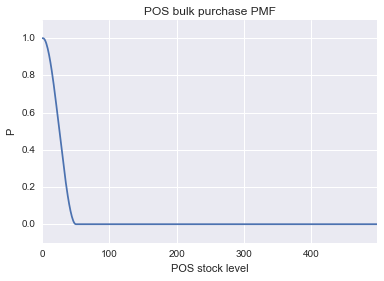

probability of bulk purchase if stock == 0: 1.0
Daily items sold to customer by each POS should follow a Binomial(10000, 0.002), 
              each pos should sell on average 20.0 items per day
Daily items sold to customer by each POS should follow a Binomial(10000, 0.002), 
              each pos should sell on average 20.0 items per day


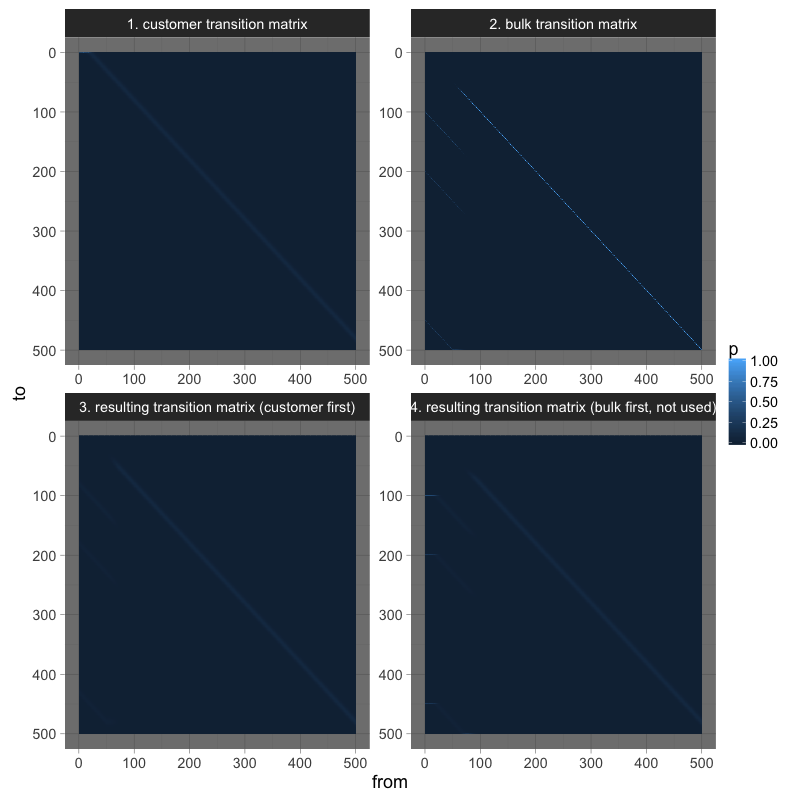

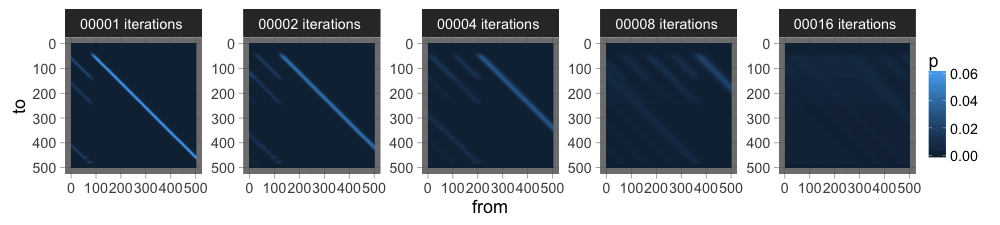

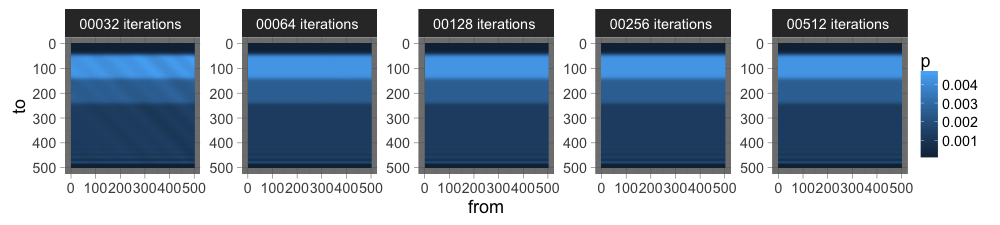

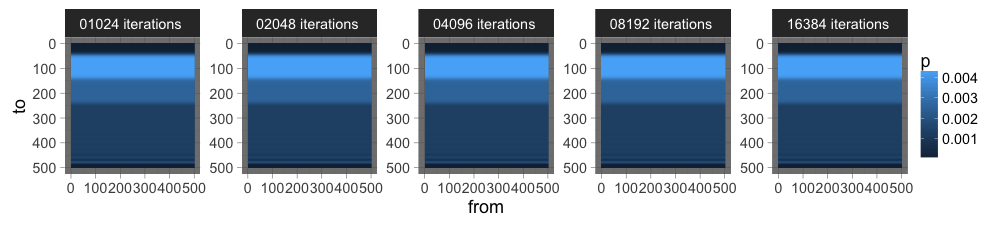

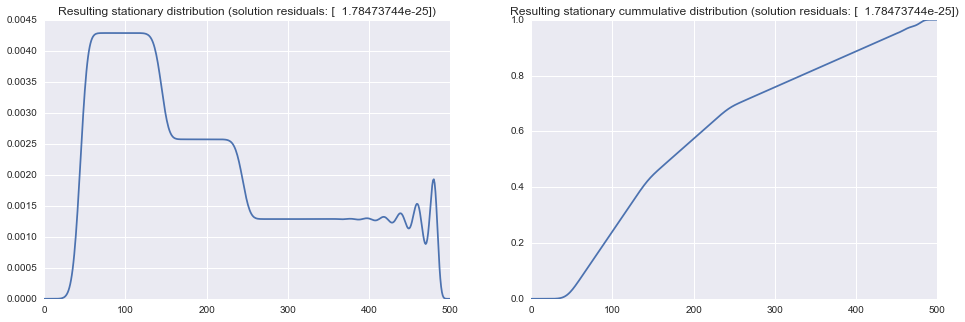

CPU times: user 4min 40s, sys: 10.6 s, total: 4min 50s
Wall time: 5min 2s


In [17]:
%%time

resulting_stationary = show_convergence({
    
    "max_stock": 500,

    "n_customers": 50000,
    "sim_buy_mean_period_days": 5,
    "n_pos": 500,

    # distribution of the purchased sim bulk sizes
    "bulk_size_distro" :{       
       100: .4,
       200: .3,
       450: .3
    },

    "bulk_trigger_params": {
        "x_min": 1,
        "x_max": 50,
        "shape": 2
    }    
})

## Saving the stationary distribution + re-using it as a generator 

In [26]:
from trumania.components import db
reload(db)

# this is necessary to re-use the distribution as starting distribution of the stock levels
db.save_empirical_discrete_generator(
    distribution=resulting_stationary,
    values=range(len(resulting_stationary)),
    namespace="stock_distro_notebook",
    gen_id="max_stock500_bulk_100_200_450"
)


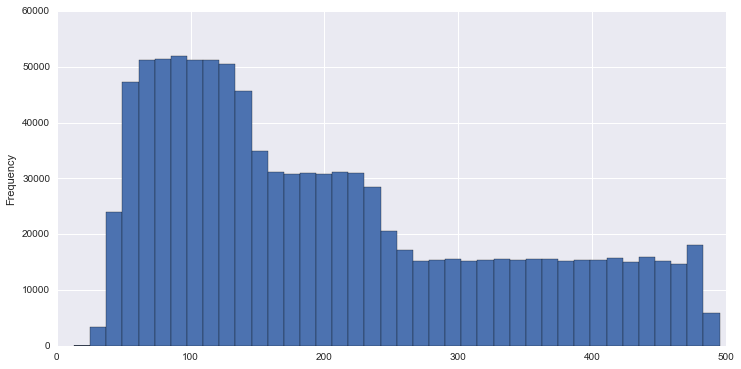

In [35]:
# just a validation: we should generate data distributed as the stationary above
gen = db.load_empirical_discrete_generator("stock_distro_notebook", 
                                          "max_stock500_bulk_100_200_450",1234)

pd.Series(gen.generate(1000000)).plot(kind="hist", bins=40, figsize=(12,6));

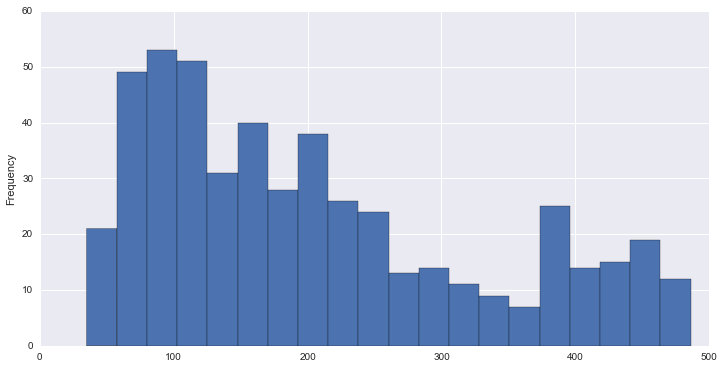

In [41]:
# that said, with just 500 POS, result will be a bit more noisy...
pd.Series(gen.generate(500)).plot(kind="hist", bins=20, figsize=(12,6));